## Progetto Cerrito - Riconoscimento e classificazione delle cellule malate di malaria

Import delle librerie necessarie al funzionamento del codice:

In [52]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout
from keras import backend as K
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as imgplt
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from PIL import Image
import matplotlib.transforms as mtransforms
import shap
import itertools
import lime
from lime import lime_image

# Parametri del modello

1. __train_data_dir__ ------------> Directory che contiene il dataset utilizzato per fare il training del modello.
2. __img_width, img_height__ -----> Dimensioni delle immagini adattate all'uso nel modello (rescaling delle stesse)
3. __nb_train_samples__ ----------> Dimensione dei campioni utilizzati nel training
4. __nb_validation_samples__ -----> Numero di campioni utilizzati durante il test del modello
5. __epochs__ --------------------> Numero di epochs utilizzate per il training del modello
6. __batch_size__ ----------------> Numero di campioni utilizzati per ogni singolo passo di training (weights adjustment)

In [53]:
out = widgets.Output(layout={'border': '1px solid black'})
out.append_stdout("Son")
train_data_dir = os.path.join('cell_images', 'Dataset')

print("Directory relativa del dataset: ", train_data_dir)

img_width, img_height = 64, 64
nb_train_samples = 3000
nb_validation_samples = 990
epochs = 50
batch_size = 16

Directory relativa del dataset:  cell_images/Dataset


# Modello della rete neurale

Si imposta la forma di input (shape) verificando l'eventuale dipendenza dal backend __image_data_format__, per uniformare la lettura delle immagini.

Si inizializza il modello inserendo __Sequential()__ che permette di utilizzare in maniera sequenziale più livelli ordinati dall'input all'output.


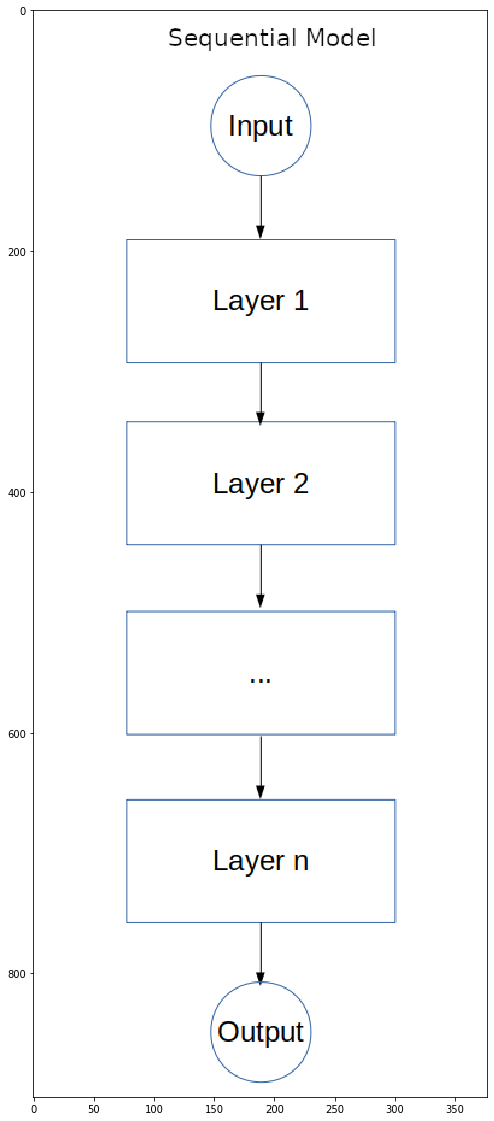

In [54]:
img = Image.open('doc_images/sequential_model.png')
plt.figure(figsize = (12, 20)) 
plt.imshow(img)

In [55]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()

## 1. Rete Convoluzionale
In seguito, si aggiunge un layer convoluzionale 2D, per analizzare le immagini in input. Osservando la figura sottostante, vi sono k funzioni kernels che vengono applicate all'immagine e producono un output 2D, detta mappa di attivazione. 

![Conv2D workflow.](./doc_images/conv2d.png "Conv2d")

Sarà necessario impostare più layer Conv2D affinchè la rete possa funzionare al meglio. 
Nel caso specifico si utilizzano 3 layer.

Primo layer: l'immagine considerata è una matrice A densa X,Y i cui valori sono vettori: $$v_{i,j} \in R^3$$
__v<sub>i,j</sub>__ rappresenta il pixel dell'immagine, tramite la rappresentazione rgb 

La matrice A è una matrice densa, tramite i vari livelli di convoluzione, la rete scompone e riduce le informazioni contenute in A, cercando di estrarre solo quelle necessarie. In particolare la Conv2D appplica k funzione kernels su porzioni dell'immagine, per produrre in output una mappa 2D. La mappa viene prodotta tramitte apprendimento di filtri. 
La complessità della matrice A comporta che al primo livello i filtri appressi sono in numero ridotto. L'uso di più livelli e funzioni Conv2D aumenta il numero di filtri appresi, anche se nel contempo, le informazioni in input vengono ridotte.

Per un corretto funzionamento della network si impostino i seguenti parametri:

1. Numero di canali in output della Conv2D (nel primo layer a 32)
2. __kernel_size__ (cioè una finestra di dimensioni 3x3 che si muove sull'immagine)
3. __strides__ (passi) nelle direzioni x e y (1, 1).
4. __activation__ funzione di attivazione a "relu: rectified linear unit" 
5. __input_shape__ precedentemente calcolata (necessaria solo per il primo livello)

L'apprendimento tramite Conv2D avviene a fasi: 
1. analizza l'immagine da sinistra verso destra e dall'alto verso il basso. Alla posizione corrente, applica i filtri e calcola la mappa
2. verifica che non ha raggiunto il bordo a destra dell'immagine, nel caso si sposta in basso di Y pixel (secondo valore di strides) e al bordo sinistro. Se non è sul bordo destro,  si sposta in avanti di x passi (primo valore di strides) e applica ancora i filtri
4. ripete i passi 1 e 2 finchè non copre l'intera immagine e termina


In [56]:
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))

### 1.1 Funzione di attivazione
keras permette di utilizzare diverse funzioni di attivazione della convoluzione:

![Activation Function](./doc_images/activation_function.png)

In particolare la funzione relu, con i parametri di default è definita come (come riportato nella documentazione di Keras):

$$relu(x)=max(x,0)$$

Altrimenti segue:

$$relu(x) =\begin{cases} maxvalue  & x \ge maxvalue \\ 
x & threshold \le x < maxvalue \\
x - threshold & altrimenti
\end{cases}$$


### 1.2 Riduzione dei valori di output di Conv2D

Per ridurre le dimensioni spaziali dell'output della convoluzione 2D, si applica la funzione __MaxPooling2D()__

In particolare con i parametri:
1. il numero di input atteso
2. __pool_size__ la dimensione del pool
3. __strides__ i passi in avanti nelle direzioni x ed y

In [32]:
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

Come indicato in precendenza aggiungiamo i layer successivi alla deep network:

In [33]:
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

## 2. Dense layer (connessione completa)

Per poter porcede alla classificazione delle immagini, dobbiamo valutare i dati in output della sottorete di convoluzione. Il modo migliore per farlo è pesare i dati ottenuti tramite l'uso di una sottorete fully connected. La __Dense()__ è rete neurale di n neuroni completamente connessi, la cui funzione è calcorare i pesi associati ai dati in input.

I parametri impostati:
1. il numero di valori in input attesi
2. __activation__ la funzione di attivazione

Il primo strato pesa i valori utilizzando la funzione relu, come definita in precendeza, in maniera da essere coerente con la rete di convoluzione. Il secondo strato, partendo dai pesi precedenti, esegue effettivamente la classificazione, nel caso specifico la classificazioni binaria, tramite la funzione di attivazione sigmoid: 

$$sigmoid(x) ={1 \over 1+e^{-x}}= {e^x \over 1 + e^x}$$

Interposta tra i due livelli Dense vi è la funzione __Dropout__, che imposta casualmente una percentuale di valori in input a 0 durante la valutazione, per prevenire ulteriormente l'overfitting.

La funzione __Flatten()__ partendo da un tensore multidimensionale, produce in output un tensore mono dimensionale. Il suo utilizzo è necessario per poter generare l'input della sottorete fully connected.

In [35]:
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

I passi fatti fino ad ora, hanno permesso di definire il modello della deep network. Dal modello, si genera la rete tramite la funzione __model.compile()__

i parametri utilizzati per generare la network:
1. La funzione di loss (perdita) da minimizzare
2. La funzione di ottimizzazione, utilizzata nel processo di apprendimento
3. La metrica utilizzata per valutare il modello generato

La classificazione che il modello prevede è una clssificazione binaria. Definendo le classi attese come: $$y \in {(0,1)}$$ la funzione di loss associata:
$$H_p(q)=-{1 \over N}\sum\limits_{i=1}^{N}y_i \log(p(y_i))+ (1-y_i) \log((1-p(y_i))$$

e p(y) è la probabilità che y appartenga alla classe 1, viceversa 1-p(y) che appartenga alla classe 0.

Analizzando la formula, si nota che per ogni punto y = 1, aggiunge il valore log(p(y)) alla funzione loss, la log probabilità di appartenere alla classe 1. viceversa, aggiunge log(1-p(y)), la log porbabilità di appartenere alla classe 0.

Poichè si sta valutando una funzione di perdita, si vuole penalizzare le predizioni errate. Se la probabilità associata è 1.0 e la classe è giusta, la loss deve essere 0, se la probabilità associata risulta essere vicino allo zero ma la classe è quella esatta, cioè abbiamo una predizione errata, la funzione loss deve essere elevata.
L'uso della funzione log, visto che il log dei valori compresi tra 0 ed 1 è negativo, prendendo il -log nella funzione, otteniamo valori positivi per la funzione loss. 

#### Entropia
L'entropia è la misura dell'incertezza associata ad una distribuzione data q(y). Per capire, se i punti dati appartenessero tutti ad una sola classe, esempio verde, l'entropia risulta essere 0, visto che predire il colore equivale ad essere certi che il colore sia giusto, coiè verde. viceversa, nel caso peggiore in cui i punti sono metà del colore verde e metà del colore rosso, non vi è nessuna possibilà di poter predire il colore, in tal caso l'entropia (l'incertezza di cosa uscirà) è massima.
L'entropia per la classificazione su C classi:
$$H(q)=-\sum\limits_{i=1}^{C}q(y_i) \log (q(y_i))$$

Per cui, conoscendo la vera distribuzione di una variabile, possiamo calcolare la sua entropia.

#### Cross Entropia
Si supponga che i punti siano approssiamti da una distribuzione nota p(y), ma che la loro vera distribuzione si q(y) e sia sconosciuta. Se calcoliamo l'entropia, cioè la cross entropia tra le due distribuzioni:
$$H_p(q)=-\sum\limits_{i=1}^{C}q(y_i) \log(p(y_i))$$

Se la distribuzione p(y) è uguale a q(y) per ogni valore, allora la cross entropia così calcolata è uguale all'entropia. Ma ne caso reale, la cross entropia assume un valore più grande dell'entropia:
$$H_p(q) - H(q) > 0$$

keras provides a lot of loss functions - see [here](https://keras.io/losses/))
2. an optimizer function to optimize our learning process (keras provides also a lot of loss functions - see [here](https://keras.io/optimizers/))
3. a metric for the model evaluation. (as before keras provides a lot of loss functions - see [here](https://keras.io/metrics/))

In [36]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Preparazione dei dati per la rete


Per convenzione vengono assegnate le seguenti label, a partire dalla directory di input:
1. unifected = 0
2. parasitized = 1

Applichiamo un split del dataset in per creare il dataset di test che corrisponde al 20% del dataset completo, applichiamo una seconda divisione del train set dividendolo al 50% tra train e validation, utilizzeremo il validation set per verificare il buon funzionamento della network in fase di predict.

In [37]:
data = []
uninfected = os.listdir(train_data_dir+"/Uninfected")
parasitized = os.listdir(train_data_dir+"/Parasitized")

for i in uninfected:
    data.append([train_data_dir+"/Uninfected/"+i,'Uninfected'])
for i in parasitized:
    data.append([train_data_dir+"/Parasitized/"+i,'Parasitized'])
random.shuffle(data)
image = [i[0] for i in data]
label = [i[1] for i in data]
del data

X_train, X_test, Y_train, Y_test = train_test_split(image, label, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.5, random_state=46)


Keras permette di utilizzare la classe __ImageDataGenerator()__ per generare un nuovo dataflow a partire da una directory su filesystem per generare l'input del nostro modello di training. Inoltre vi sono funzioni che ci permettono di randomizzare e manipolare le immagini prima di caricarle come input del modello, permettendo di fare un training più accurato.

Infatti faremo in modo che le immagini subiscano queste trasformazioni, in maniera tale che il modello non venda due volte di seguito la stessa immagine. Ciò permetterà di evitare (o almeno ridurre drasticamente) l'overfitting del modello. Inoltre il modello risultante sarà più generalizzato.

I parametri impostati sono:

* __rotation_range__ valore in gradi compreso tra 0 e 180°, con il quale il modello ruoterà randomicamente le immagini.
* __width_shift__ e __height_shift__ intervalli dati come frazioni delle dimensioni totali di cui il modello transla orizzontalmente e verticalmente le immagini randomicamente.
* __rescale__  è un valore con cui saranno riscalati i dati in input prima di qualsiasi altro prcoesso. Le immagini originali consistono in coefficienti RGB dati come valori tra 0 e 255, ma tali valori sono troppo alti per il modello, per cui li riscaliamo in maniera che siano compresi tra 0 e 1 .
* __shear_range__ percentuale di applicazione di funzioni di taglio randomiche
* __zoom_range__ percentuale di applicazioni di funzioni di zoom randomiche.
* __horizontal_flip__  per capovolgere metà delle immagini orizzontalmente, vale a dire quando non ci sono assunzioni di asimmetria orizzontale (ad esempio nel caso di immagini reali)
* __fill_mode__ è la funzione utilizzata per generare i pixel che potrebbero essere creati dalla funzione di rotazione o dalla translazione.

In [38]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

## Caricamento immagini da una directory (e relative sottodirectory)

Generiamo dei dataframe per avere una tabella Filename e Label associata, a partire dai dataset generati in precendenza, ricordiamo che X_train sono le immagini, Y_train le label associate, così anche per la parte test e validation.



In [39]:
x_train_dataframe = pd.DataFrame({'Filename':X_train, 'Label':Y_train})
x_testval_dataframe = pd.DataFrame({'Filename':X_test, 'Label':Y_test})
x_validation_dataframe = pd.DataFrame({'Filename':X_val, 'Label':Y_val})

x_train_dataframe.head(4)

,Filename,Label
0,cell_images/Dataset/Uninfected/C37BP2_thinF_IM...,Uninfected
1,cell_images/Dataset/Parasitized/C132P93ThinF_I...,Parasitized
2,cell_images/Dataset/Uninfected/C77P38ThinF_IMG...,Uninfected
3,cell_images/Dataset/Uninfected/C56P17thinF_IMG...,Uninfected


## Training e test generator

Kera per mette di creare e caricare le immagini direttamente a partire dai dataframe, tramite l'uso dei generator. Nel caso specifico, utilizziamo la funzione __flow_from_dataframe__, passando anche i parametri batch_size e le dimensioni a cui riscalare le immagini.

Il parametro __directory__ viene posto a None, visto che nell'X_train e nel X_test sono già specificati i percorsi per ogni immagine.

In [40]:
X_train_generator = train_datagen.flow_from_dataframe(dataframe = x_train_dataframe,directory = None, x_col = 'Filename', y_col = 'Label', class_mode = 'binary', batch_size = batch_size, target_size=(img_width, img_height))
X_testval_generator = train_datagen.flow_from_dataframe(dataframe = x_testval_dataframe,directory = None, x_col = 'Filename', y_col = 'Label', class_mode = 'binary', batch_size = batch_size, target_size=(img_width, img_height))

Found 11023 validated image filenames belonging to 2 classes.
Found 5512 validated image filenames belonging to 2 classes.


# Modello Generato

Utilizzando la funzione __summary__, possiamo vedere un riassunto della network generata secondo il modello impostato.

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
__________

# Libreria SHAP

Utilizziamo la libreria SHAP per avere una visione migliore del modello, utilizzando l'explainer __DeepExplainer__, analizzando il modello con 200 elementi del train dataset e 20 explanations.

In [42]:
#codice per generator

## Training del modello

A questo punto verifichiamo l'esistenza dei file __malaria_weights.h5__, __malaria_model_trained__ e __validation_dataframe.csv__, in tal caso li carichiamo, altrimenti passiamo a fare il training della rete.

Avendo utilizzato i generator di keras, il training sarà fatto tramite la funzione __fit_generator__, con i parametri:

1. Il training dataset
2. __step_per_epoch__ i passi necessari per ogni epoch, che sarà il numero di campioni di training diviso la dimensione di batch.
3. __epochs__ il numero di epoch con cui vagliamo fare il training del modello.
4. __validation_data__ il dataset di test per validare il modello.
5. __validation_steps__ i passi necessari per ogni epoch per la validazione, che sarà il numero di campioni di test diviso la dimensione di batch.


In [43]:
savemod = 1
if os.path.exists('saved_model/malaria_weights.h5') and os.path.exists('saved_model/malaria_model_trained.mod') and os.path.exists('saved_model/validation_dataframe.csv'):
    history = load_model('saved_model/malaria_model_trained.mod')
    history.load_weights('saved_model/malaria_weights.h5')
    x_validation_dataframe = pd.read_csv('saved_model/validation_dataframe.csv')
    savemod = 0

else:
    history = model.fit_generator(
        X_train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=X_testval_generator,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
187/187 [==============================] - 55s 295ms/step - loss: 0.7020 - acc: 0.5060 - val_loss: 0.6948 - val_acc: 0.4928
Epoch 2/50
187/187 [==============================] - 52s 277ms/step - loss: 0.6506 - acc: 0.6464 - val_loss: 0.5851 - val_acc: 0.6814
Epoch 3/50
187/187 [==============================] - 51s 275ms/step - loss: 0.4659 - acc: 0.8025 - val_loss: 0.3529 - val_acc: 0.8627
Epoch 4/50
187/187 [==============================] - 51s 272ms/step - loss: 0.3397 - acc: 0.8639 - val_loss: 0.3651 - val_acc: 0.8402
Epoch 5/50
187/187 [==============================] - 51s 270ms/step - loss: 0.3290 - acc: 0.8783 - val_loss: 0.2977 - val_acc: 0.9068
Epoch 6/50
187/187 [==============================] - 50s 270ms/step - loss: 0.3062 - acc: 0.8937 - val_loss: 0.3179 - val_acc: 0.8781
Epoch 7/50
187/187 [==============================] - 51s 272ms/step - loss: 0.3013 - acc: 0.8964 - val_loss: 0.2638 - val_acc: 0.9160
Epoch 8/50
187/187 [==============================] - 5

# Validità del modello
## 1. Informazioni loss e accuracy
Valutiamo il modello mediante la funzione __evaluate_generator__, necessaria quando si utilizzano i generator di Keras, utilizzando il dataset di test (Validation), per verificare i valori di loss e accuracy:

In [44]:
step_size_testval = X_testval_generator.n // batch_size
score=model.evaluate_generator(generator=X_testval_generator,steps=step_size_testval, verbose=0)
print('Loss sul dataset di test:', score[0])
print('Accuracy sul dataset di test:', score[1])


Loss sul dataset di test: 0.280184844348802
Accuracy sul dataset di test: 0.9215793304221251


## 2. Plot del grafico
Salvando il processo di training, abbiamo la possibilità di poter stampare le metriche in un grafico. Osservando il grafico, si nota già che circa dopo solo 10 epochs, il modello sale  a circa il 90% di accuracy sul dataset di training e su quello di testing. Si noto anche che sul dataset di test l'accuracy non è delle migliori, ma manteniamo il modello in queste circostanze, per evitare di avere overfitting sui dati. Infatti se guardiamo al test accuracy, otteniamo un solo 50%.
Potremmo migliorare aoncora il modello, cambiando la seconda Conv2D in maniera che prenda 64 input, la terza Conv2D ne prenda 128, così potremmo utilizzare le immagini ridimensionate a 128px, aumentare anche il numero di epochs, ma in tal modo il tempo di training aumenta in maniera esponenziale. Avendo a disposizione una macchina non tra le migliori per poter eseguire processi di Machine Learning, accettiamo il compromesso scelto, che comunque da ottimi risultati.

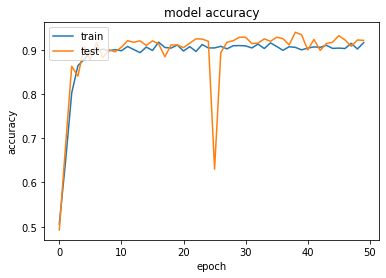

In [45]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Salvataggio del modello

Per non dover rifare il training ogni volta che eseguiamo il codice, è buona norma salvare il modello già pronto, da poterlo riutilizzare in qualsiasi momento. Per cui:

1. Salviamo i pesi risultanti del modello (weights) senza salvare l'architettura. (utile se vogliamo per esempio spostare il modello su un divero framework)
2. Salviamo l'intero modello, così che keras è in grado di caricarlo ed utilizzarlo.
3. Salviamo __x_validation_dataframe__ su csv, in questo modo possiamo tener traccia del dataset di validation, cioè le immagini che abbiamo escludo dal dataset di training e di test, quando abbiamo inizializzato il modello. (se cancelliamo il modello salvato, i pesi e il csv, il modello viene reinizializzato, ma i dataset di training, test e validation vengono generati in maniera casuale, per cui saranno sempre diversi)


In [46]:
# Save weights for further use
if savemod:
    model.save_weights('saved_model/malaria_weights.h5')
    model.save('saved_model/malaria_model_trained.mod')
    x_validation_dataframe.to_csv('saved_model/validation_dataframe.csv')

# Fit sui dati di validation
Il nostro modello a questo punto è pronto a fare anche le previsioni su delle immagini che non ha mai "visto", per cui verifichiamo il buon funzionamento. Avendo generato un dataset di validazione, lo utilizziamo per fare fit. Stampiamo i risultati, avendo nel dataset anche le etichette associate alle immagini (Uninfected, Parasized), calcoliamo quanti falsi positivi (cellule uninfected riconosciute come malate, caso meno grave) e quanti falsi negativi (cellule malate riconosciute come non infette; caso più grave). Visto il numero alto di immagini, la stampa richiede un pò di tempo, per velocizzare, possiamo anche decommentare la __if.....break__ per avere il grafico sulle prime 1000 istanze.

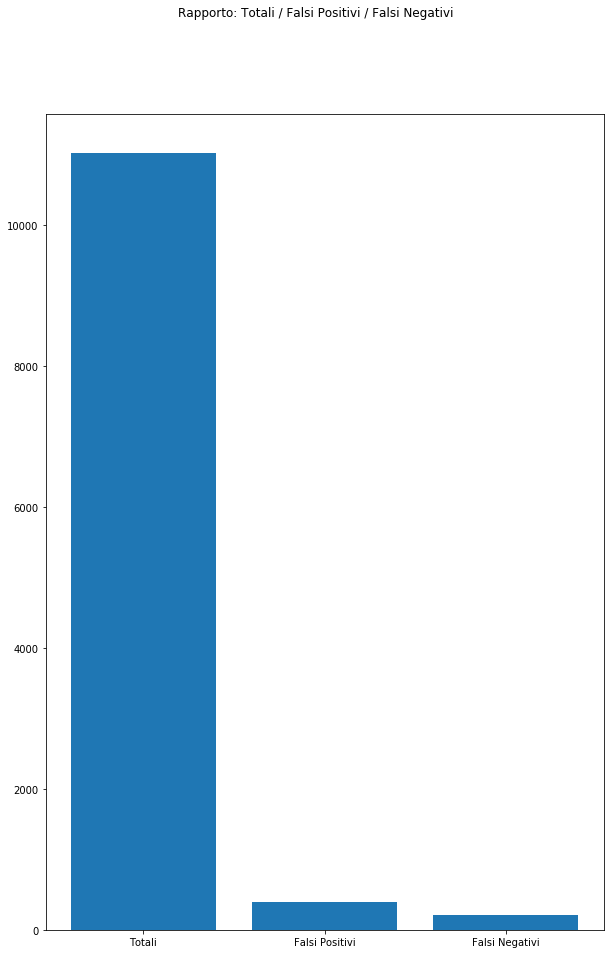

In [49]:
count=0
false_negative = 0
false_positive = 0

if savemod:
    for row in x_validation_dataframe.itertuples(index=True, name='Pandas'):
        img = Image.open(getattr(row, "Filename"))
        label = getattr(row, "Label")
        img = img.convert("RGB")
        img = img.resize((img_width, img_height), Image.ANTIALIAS)
        img = img_to_array(img)
        img = img/255.0
        img = img.reshape((1,) + img.shape)
        pred = model.predict(img)
        pred = pred.item(0)
        pred = np.round(pred, decimals = 3)
        if pred > 0.500 and label == 'Parasitized':
            false_negative = false_negative + 1
        if pred <= 0.500 and label == 'Uninfected':
            false_positive = false_positive + 1
        count=count + 1
        #if count >1000:
        #    break;               
    data = {'Totali' : count, 'Falsi Positivi' : false_positive, 'Falsi Negativi' : false_negative}
    dataf = pd.DataFrame.from_dict(data, orient="index")
    dataf.to_csv('saved_model/predicted_data.csv')
else:
    dataf = pd.read_csv('saved_model/predicted_data.csv', index_col=0)
    data = dataf.to_dict("split")
    data = dict(zip(d["index"], d["data"]))

    
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 1, figsize=(10, 15), sharey=True)
axs.bar(names, values)
fig.suptitle('Rapporto: Totali / Falsi Positivi / Falsi Negativi')
plt.show()

